In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# 残差网络（ResNet）

> 随着网络深度增加，我们总是能够获得更好的精度么？

## 函数类

- 假设有一类特定的神经网络架构$\mathcal{F}$，包括学习速率和其他超参数设置
- 对于所有$f \in \mathcal{F}$，存在一些参数集（例如权重和偏置），这些参数可以通过在合适的数据集上进行训练而获得
- 现在假设$f^*$是真正想要找到的函数，如果是$f^* \in \mathcal{F}$，可以轻而易举的训练得到它

- 如果$f^* \notin \mathcal{F}$，将尝试找到$\mathcal{F}$中的最佳选择$f^*_\mathcal{F}$
- 例如，给定一个具有$\mathbf{X}$特性和$\mathbf{y}$标签的数据集，可以尝试通过解决以下优化问题来找到它：

$$f^*_\mathcal{F} := \mathop{\mathrm{argmin}}_f L(\mathbf{X}, \mathbf{y}, f) \text{ subject to } f \in \mathcal{F}.$$

- 如何得到$f^*_\mathcal{F}$?
    - 需要设计一个更强大的架构$\mathcal{F}'$
    - 即，预计$f^*_{\mathcal{F}'}$比$f^*_{\mathcal{F}}$“更近似”

- 然而，如果$\mathcal{F} \not\subseteq \mathcal{F}'$，则无法保证新的体系“更近似”

<center><img src='../img/6_convolutional_neural_networks/resnet_background.png'></center>

- 上图中，$f$是最好的模型，$F$是模型大小（复杂度由$\mathcal{F}_1$向$\mathcal{F}_6$递增）
- 左侧：非嵌套函数（non-nested function）类，较复杂的函数类并不总是向“真”函数$f^*$靠拢
- 右侧：右侧的嵌套函数（nested function）类$\mathcal{F}_1 \subseteq \ldots \subseteq \mathcal{F}_6$，可以避免上述问题

- 对于深度神经网络，如果能将新添加的层训练成*恒等映射*（identity function）$f(\mathbf{x}) = \mathbf{x}$，新模型和原模型将同样有效。
- 同时，由于新模型可能得出更优的解来拟合训练数据集，因此添加层似乎更容易降低训练误差

## 残差块

- 残差网络的核心思想：每个附加层都应该更容易地包含原始函数作为其元素之一

假设原始输入为$x$，而希望学出的理想映射为$f(\mathbf{x})$
- 左图虚线框中的部分需要直接拟合出该映射$f(\mathbf{x})$
- 右图虚线框中的部分则需要拟合出残差映射$f(\mathbf{x}) - \mathbf{x}$，ResNet的基础架构--*残差块*（residual block）

<center><img src="../img/6_convolutional_neural_networks/residual-block.svg" width=80%></center>

### 残差块的构成

- ResNet残差块里首先有2个有相同输出通道数的$3\times 3$卷积层
- 每个卷积层后接一个批量规范化层和ReLU激活函数
- 然后通过跨层数据通路，跳过这2个卷积运算，将输入直接加在最后的ReLU激活函数前
- 如果想改变通道数，需要引入一个额外的$1\times 1$卷积层来将输入变换成需要的形状后再做相加运算

<center><img src='../img/6_convolutional_neural_networks/resnetblock.png' width=100%></center>

### 残差块的实现

In [3]:
class Residual(nn.Module):  
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels) # 每个bn有自己的参数
        # self.relu = nn.ReLU(inplace=True) #inplace参数可以节省内存

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

测试：（1）输入和输出形状一致

In [4]:
blk = Residual(3,3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

测试：(2)增加输出通道数的同时，减半输出的高和宽

In [5]:
blk = Residual(3,6, use_1x1conv=True, strides=2) # 我们经常让高宽减半时，把通道数加倍
blk(X).shape

torch.Size([4, 6, 3, 3])

## 残差块的不同形式

<center><img src='../img/6_convolutional_neural_networks/resnetblks.png' withd=100%></center>

# ResNet模型

## 架构

- 全部结构

<center><img src='../img/6_convolutional_neural_networks/resnet_structure.png' align='top'><center>

- 局部结构

<center><img src='../img/6_convolutional_neural_networks/resnet_struct_local.png' align="top"></center>

- ResNet的前两层：
    - 在输出通道数为64、步幅为2的$7 \times 7$卷积层后，接步幅为2的$3 \times 3$的最大汇聚层
    - 每个卷积层后增加了批量规范化层。

In [6]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

- ResNet则使用4个由残差块组成的模块，每个模块使用若干个同样输出通道数的残差块
    - 第一个模块的通道数同输入通道数一致
    - 之后的每个模块在第一个残差块里将上一个模块的通道数翻倍，并将高和宽减半

In [7]:
def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    """残差块组成的模块"""
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

In [8]:
# 在ResNet加入所有残差块，这里每个模块使用2个残差块
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

 - 最后在ResNet中加入全局平均汇聚层，以及全连接层输出

In [9]:
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

- 每个模块有4个卷积层（不包括恒等映射的$1\times 1$卷积层），加上第一个$7\times 7$卷积层和最后一个全连接层，共有18层。因此，这种模型通常被称为ResNet-18

- 观察ResNet中不同模块的输入形状是如何变化

In [10]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


## 训练模型

loss 0.011, train acc 0.997, test acc 0.915
4701.1 examples/sec on cuda:0


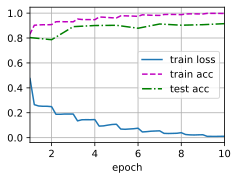

In [9]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, try_gpu())

# 总结

- 为什么叫残差网络？
    - 允许原始输入信息直接传到后面的层中，这一层的神经网络可以不用学习整个的输出，而是学习上一个网络输出的残差（输出-输入），因此ResNet又叫做残差网络。

- Resnet的优势
    - 残差块使得很深的网络更加容易训练。甚至可以训练一千层的网络。
    - 残差网络对随后的深层神经网络设计产生了深远影响，无论是卷积类网络还是全连接类网络。

- Resnet为什么会有这样的优势？

- 数据层（底层）和loss层（顶层）训练的不平衡问题。
- 梯度传递的时候，存在相加过程，底层的梯度不会太小，缓解了梯度爆炸。